In [1]:
import time
import sys
import os
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision.models.efficientnet import MBConvConfig, FusedMBConvConfig

import optuna

sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab2-group6/code/modeling")
from preprocessing import to_NCHW, pad_to_384x384, standardize_images
from autoencoder import EfficientNetEncoder, EfficientNetDecoder, AutoencoderConfig
from classification import masked_bce_loss, masked_hinge_loss, l1_reg

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

use_amp = True

/jet/home/azhang19/.conda/envs/env_214/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("optuna_study.pkl", "rb") as f:
    study = pickle.load(f)

In [3]:
study.trials

[FrozenTrial(number=0, state=1, values=[0.73673415184021], datetime_start=datetime.datetime(2025, 3, 8, 19, 37, 49, 280239), datetime_complete=datetime.datetime(2025, 3, 8, 19, 37, 53, 502030), params={'epochs': 387, 'lr': 0.09986165745939864, 'weight_decay': 9.209560372323633e-05, 'optimizer': 'SGD', 'kernel_size': 2, 'loss_mix_ratio': 0.1731682913442203, 'l1': 0.00924777748750829, 'block1': 1, 'block2': 2, 'block3': 2, 'flip': False, 'rotate': True, 'autoencoder_epoch': 4, 'with_orginal': False}, user_attrs={'val_acc': 0.8169143795967102}, system_attrs={}, intermediate_values={}, distributions={'epochs': IntDistribution(high=800, log=False, low=0, step=1), 'lr': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=1.0, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('SGD', 'AdamW')), 'kernel_size': IntDistribution(high=5, log=False, low=1, step=1), 'loss_mix_ratio': FloatDistribution(high=1.0, log=False, l

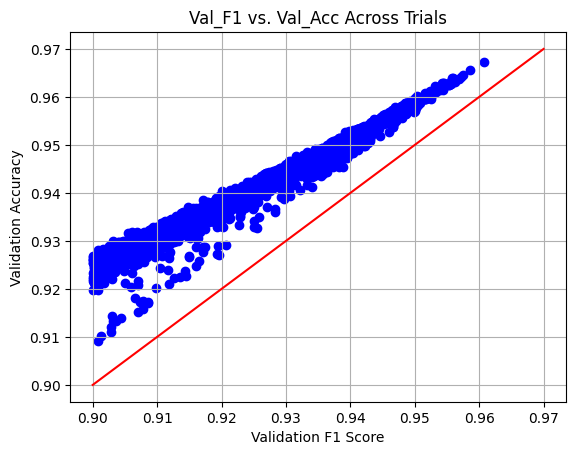

In [15]:
import matplotlib.pyplot as plt

f1_scores = [trial.value for trial in study.trials]
acc_scores = [trial.user_attrs["val_acc"] for trial in study.trials]

f1_scores = np.array(f1_scores)
acc_scores = np.array(acc_scores)

idx = f1_scores > 0.9
f1_scores = f1_scores[idx]
acc_scores = acc_scores[idx]

# Add x=y line
plt.plot([0.9, 0.97], [0.9, 0.97], c="red")

plt.scatter(f1_scores, acc_scores, c="blue", alpha=1)
plt.xlabel("Validation F1 Score")
plt.ylabel("Validation Accuracy")
plt.title("Val_F1 vs. Val_Acc Across Trials")
plt.grid(True)
plt.show()
# Optional: Save to file
# plt.savefig("f1_vs_acc.png")

In [17]:
np.max(f1_scores)

np.float64(0.9607895016670227)

In [37]:
import numpy as np
import os

def get_img_mask(data):
    """
    Convert coordinate-based data into image and mask arrays.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input array with shape (n_points, n_features) where first two columns are coordinates
        
    Returns:
    --------
    img : numpy.ndarray
        3D array containing image data with shape (x_size, y_size, n_features-2)
    mask : numpy.ndarray
        2D binary mask array with shape (x_size, y_size)
    """
    # Extract and normalize coordinates
    idx = data[:, 0:2].astype(int)
    idx = idx - idx.min(axis=0)
    
    x_coords = idx[:, 1]
    y_coords = idx[:, 0]
    
    # Calculate image dimensions
    x_size = x_coords.max() - x_coords.min() + 1
    y_size = y_coords.max() - y_coords.min() + 1
    
    # Create image and mask arrays
    img = np.zeros((x_size, y_size, data.shape[1] - 2))
    mask = np.zeros((x_size, y_size))
    
    # Fill arrays with data
    img[x_coords, y_coords] = data[:, 2:]
    mask[x_coords, y_coords] = 1
    
    return img, mask

data_path = "/jet/home/azhang19/stat 214/stat-214-lab2-group6/data/org"
npz_data = np.load(os.path.join(data_path, "O013257.npz"))
key = list(npz_data.files)[0]
data = npz_data[key]

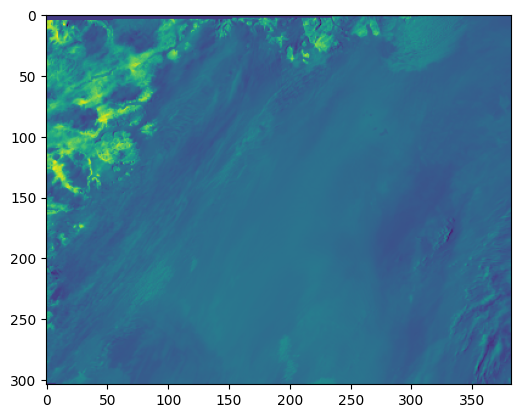

In [38]:
img = get_img_mask(data)[0]
import matplotlib.pyplot as plt

plt.imshow(img[:, :, 0])

In [27]:
# Load and preprocess data
data = np.load("/jet/home/azhang19/stat 214/stat-214-lab2-group6/data/array_data.npz")
unlabeled_images, unlabeled_masks, labeled_images, labeled_masks, labels = data["unlabeled_images"], data["unlabeled_masks"], data["labeled_images"], data["labeled_masks"], data["labels"]

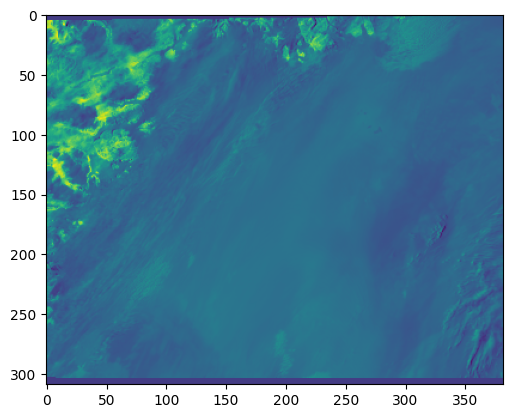

In [36]:
plt.imshow(labeled_images[1, :, :, 0])